<a href="https://colab.research.google.com/github/AndreaCastiella/Sequences-Time-Series-and-Prediction/blob/main/S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-05-07 13:24:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.006s  

2021-05-07 13:24:56 (11.4 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



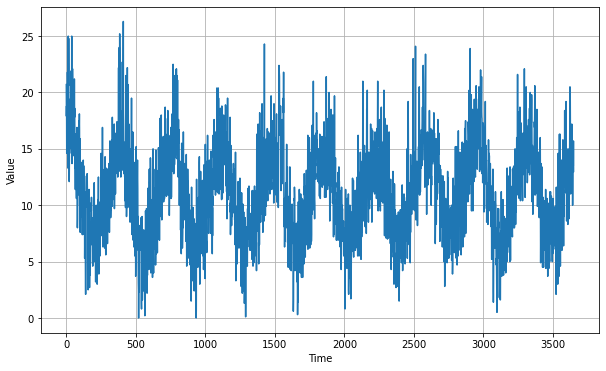

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for step, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(step)
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 0, 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    # YOUR CODE HERE

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
]) # YOUR CODE HERE

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 52ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 1s 60ms/step - loss: 30.7697 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 1s 60ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 1s 54ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 1s 55ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 1s 61ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 1s 58ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 1s 62ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 1s 59ms/step - loss: 18.2363 - mae: 18.7316
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

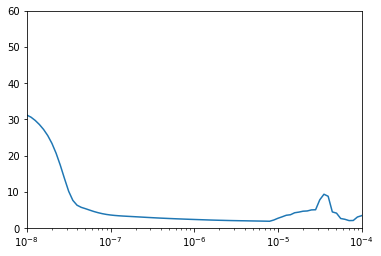

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
]) # YOUR CODE HERE


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 5s 35ms/step - loss: 12.0756 - mae: 12.5671
Epoch 2/150
25/25 [==============================] - 1s 35ms/step - loss: 2.5921 - mae: 3.0554
Epoch 3/150
25/25 [==============================] - 1s 36ms/step - loss: 2.0223 - mae: 2.4783
Epoch 4/150
25/25 [==============================] - 1s 35ms/step - loss: 1.9227 - mae: 2.3756
Epoch 5/150
25/25 [==============================] - 1s 36ms/step - loss: 1.8905 - mae: 2.3430
Epoch 6/150
25/25 [==============================] - 1s 36ms/step - loss: 1.8497 - mae: 2.3014
Epoch 7/150
25/25 [==============================] - 1s 35ms/step - loss: 1.8167 - mae: 2.2685
Epoch 8/150
25/25 [==============================] - 1s 37ms/step - loss: 1.7909 - mae: 2.2411
Epoch 9/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7701 - mae: 2.2196
Epoch 10/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7349 - mae: 2.1838
Epoch 11/150
25/25 [===========================

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

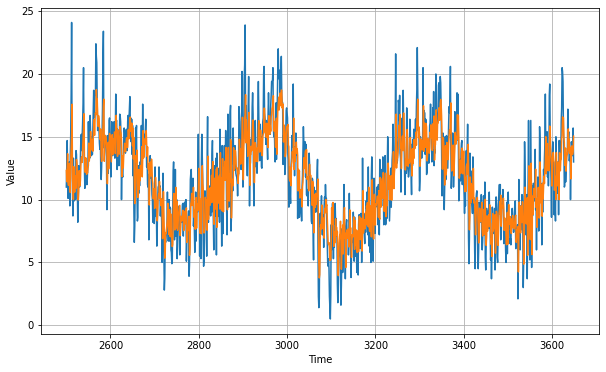

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7895154

In [19]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.314678 11.424784 12.480337 ... 13.594207 13.807485 15.049669]
